## Group Two
## Dr. Tweneboah
## CMPS 620 - Final Project
## 2 April 2021
---

In [1]:
import os
import random

import graphviz
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as sk

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, KFold, ShuffleSplit
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
np.random.seed(42)

## Utility Functions
### Author: Kyle Calabro
---

In [2]:
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None, n_jobs = -1, train_sizes = np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel("Training Instances")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, n_jobs = n_jobs, scoring = "accuracy", train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = .1, color = "r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = .1, color = "b")

    plt.plot(train_sizes, train_scores_mean, "o-", color = "r", label = "Training Score")
    plt.plot(train_sizes, test_scores_mean, "o-", color = "b", label = "CV Score")

    plt.legend(loc = "best")
    return plt;

In [3]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize = 16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize = 16)    
    plt.grid(True);  

In [4]:
def get_roc_plot(classifier_preds, eval_set):
    fpr, tpr, thresholds = sk.roc_curve(eval_set, classifier_preds)
    auc = sk.auc(fpr, tpr)
    plt.figure(figsize=(8, 6))                        
    plot_roc_curve(fpr, tpr)
    plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") 
    plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  
    plt.plot([4.837e-3], [0.4368], "ro")               
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.show();

In [5]:
def print_performance_metrics(eval_set, classifier_preds):
    print("Confusion Matrix:")
    print(sk.confusion_matrix(eval_set, classifier_preds), "\n")
    print("Classification Report:")
    print(sk.classification_report(eval_set, classifier_preds), "\n")
    print("Accuracy:", sk.accuracy_score(eval_set, classifier_preds))

## Bringing in the Data
### Author: Kyle Calabro
----

In [6]:
gpu_df = pd.read_csv("./data/sgemm_product.csv")
gpu_df.shape

(241600, 18)

## Exploratory Data Analysis and Pre-Processing
### Author: Kyle Calabro
---

In [7]:
gpu_df.head()

MWG  NWG  KWG  MDIMC  NDIMC  MDIMA  NDIMB  KWI  VWM  VWN  STRM  STRN  SA  \
0   16   16   16      8      8      8      8    2    1    1     0     0   0   
1   16   16   16      8      8      8      8    2    1    1     0     0   0   
2   16   16   16      8      8      8      8    2    1    1     0     0   1   
3   16   16   16      8      8      8      8    2    1    1     0     0   1   
4   16   16   16      8      8      8      8    2    1    1     0     1   0   

   SB  Run1 (ms)  Run2 (ms)  Run3 (ms)  Run4 (ms)  
0   0     115.26     115.87     118.55     115.80  
1   1      78.13      78.25      79.25      79.19  
2   0      79.84      80.69      80.76      80.97  
3   1      84.32      89.90      86.75      85.58  
4   0     115.13     121.98     122.73     114.81

### Create new target variable Runtime as the average of the four runtimes given from original data set.

In [8]:
gpu_df["Runtime"] = gpu_df[["Run1 (ms)", "Run2 (ms)", "Run3 (ms)", "Run4 (ms)"]].mean(axis = 1)

### Drop the old runtime variables.

In [9]:
gpu_df = gpu_df.drop(columns = ["Run1 (ms)", "Run2 (ms)", "Run3 (ms)", "Run4 (ms)"], axis = 1)
gpu_df.head()

MWG  NWG  KWG  MDIMC  NDIMC  MDIMA  NDIMB  KWI  VWM  VWN  STRM  STRN  SA  \
0   16   16   16      8      8      8      8    2    1    1     0     0   0   
1   16   16   16      8      8      8      8    2    1    1     0     0   0   
2   16   16   16      8      8      8      8    2    1    1     0     0   1   
3   16   16   16      8      8      8      8    2    1    1     0     0   1   
4   16   16   16      8      8      8      8    2    1    1     0     1   0   

   SB   Runtime  
0   0  116.3700  
1   1   78.7050  
2   0   80.5650  
3   1   86.6375  
4   0  118.6625

In [10]:
gpu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241600 entries, 0 to 241599
Data columns (total 15 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   MWG      241600 non-null  int64  
 1   NWG      241600 non-null  int64  
 2   KWG      241600 non-null  int64  
 3   MDIMC    241600 non-null  int64  
 4   NDIMC    241600 non-null  int64  
 5   MDIMA    241600 non-null  int64  
 6   NDIMB    241600 non-null  int64  
 7   KWI      241600 non-null  int64  
 8   VWM      241600 non-null  int64  
 9   VWN      241600 non-null  int64  
 10  STRM     241600 non-null  int64  
 11  STRN     241600 non-null  int64  
 12  SA       241600 non-null  int64  
 13  SB       241600 non-null  int64  
 14  Runtime  241600 non-null  float64
dtypes: float64(1), int64(14)
memory usage: 27.6 MB


In [11]:
gpu_df.describe().T

count        mean         std      min      25%    50%       75%  \
MWG      241600.0   80.415364   42.469220  16.0000  32.0000  64.00  128.0000   
NWG      241600.0   80.415364   42.469220  16.0000  32.0000  64.00  128.0000   
KWG      241600.0   25.513113    7.855619  16.0000  16.0000  32.00   32.0000   
MDIMC    241600.0   13.935894    7.873662   8.0000   8.0000   8.00   16.0000   
NDIMC    241600.0   13.935894    7.873662   8.0000   8.0000   8.00   16.0000   
MDIMA    241600.0   17.371126    9.389418   8.0000   8.0000  16.00   32.0000   
NDIMB    241600.0   17.371126    9.389418   8.0000   8.0000  16.00   32.0000   
KWI      241600.0    5.000000    3.000006   2.0000   2.0000   5.00    8.0000   
VWM      241600.0    2.448609    1.953759   1.0000   1.0000   2.00    4.0000   
VWN      241600.0    2.448609    1.953759   1.0000   1.0000   2.00    4.0000   
STRM     241600.0    0.500000    0.500001   0.0000   0.0000   0.50    1.0000   
STRN     241600.0    0.500000    0.500001   0.0000   0.0000   0.50    1.0000   
SA       241600.0    0.500000    0.500001   0.0000   0.0000   0.50    1.0000   
SB       241600.0    0.500000    0.500001   0.0000   0.0000   0.50    1.0000   
Runtime  241600.0  217.571953  368.750161  13.3175  40.6675  69.79  228.3875   

               max  
MWG       128.0000  
NWG       128.0000  
KWG        32.0000  
MDIMC      32.0000  
NDIMC      32.0000  
MDIMA      32.0000  
NDIMB      32.0000  
KWI         8.0000  
VWM         8.0000  
VWN         8.0000  
STRM        1.0000  
STRN        1.0000  
SA          1.0000  
SB          1.0000  
Runtime  3341.5075

### Checking for null values:

In [12]:
gpu_df.isnull().sum()

MWG        0
NWG        0
KWG        0
MDIMC      0
NDIMC      0
MDIMA      0
NDIMB      0
KWI        0
VWM        0
VWN        0
STRM       0
STRN       0
SA         0
SB         0
Runtime    0
dtype: int64

### Check for outliers:

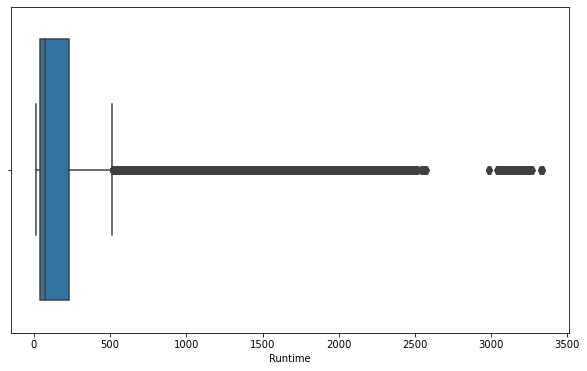

In [13]:
plt.figure(figsize = (10, 6))
sns.boxplot(gpu_df["Runtime"]);

### As we can see, there are some outliers.
### We will remove them:

In [14]:
first_quantile = gpu_df["Runtime"].quantile(.25)
second_quantile = gpu_df["Runtime"].quantile(.75)

inner_quantile = second_quantile - first_quantile

lower_limit = first_quantile - 1.5 * inner_quantile
upper_limit = second_quantile + 1.5 * inner_quantile

filtered_df = gpu_df[(gpu_df["Runtime"] > lower_limit) & (gpu_df["Runtime"] < upper_limit)]
filtered_df.describe().T

count        mean         std      min     25%    50%       75%  \
MWG      214833.0   75.688037   41.968313  16.0000  32.000  64.00  128.0000   
NWG      214833.0   75.761619   41.997377  16.0000  32.000  64.00  128.0000   
KWG      214833.0   25.592567    7.839899  16.0000  16.000  32.00   32.0000   
MDIMC    214833.0   14.475690    8.111065   8.0000   8.000  16.00   16.0000   
NDIMC    214833.0   14.470700    8.111264   8.0000   8.000  16.00   16.0000   
MDIMA    214833.0   17.390550    9.375134   8.0000   8.000  16.00   32.0000   
NDIMB    214833.0   17.388762    9.374445   8.0000   8.000  16.00   32.0000   
KWI      214833.0    5.005544    3.000002   2.0000   2.000   8.00    8.0000   
VWM      214833.0    2.339538    1.858623   1.0000   1.000   2.00    4.0000   
VWN      214833.0    2.345156    1.862122   1.0000   1.000   2.00    4.0000   
STRM     214833.0    0.500580    0.500001   0.0000   0.000   1.00    1.0000   
STRN     214833.0    0.500044    0.500001   0.0000   0.000   1.00    1.0000   
SA       214833.0    0.486038    0.499806   0.0000   0.000   0.00    1.0000   
SB       214833.0    0.485056    0.499778   0.0000   0.000   0.00    1.0000   
Runtime  214833.0  114.554350  113.825481  13.3175  39.095  61.79  157.8925   

              max  
MWG      128.0000  
NWG      128.0000  
KWG       32.0000  
MDIMC     32.0000  
NDIMC     32.0000  
MDIMA     32.0000  
NDIMB     32.0000  
KWI        8.0000  
VWM        8.0000  
VWN        8.0000  
STRM       1.0000  
STRN       1.0000  
SA         1.0000  
SB         1.0000  
Runtime  509.9625

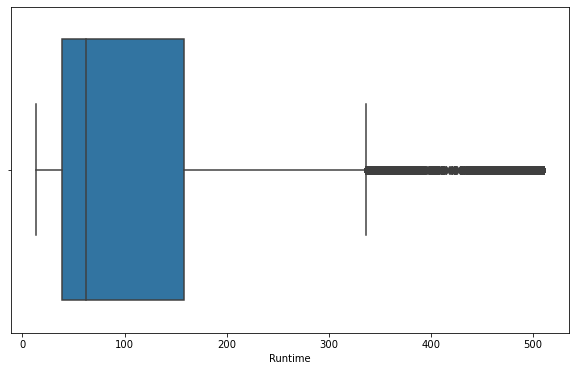

In [15]:
plt.figure(figsize = (10, 6))
sns.boxplot(filtered_df["Runtime"]);

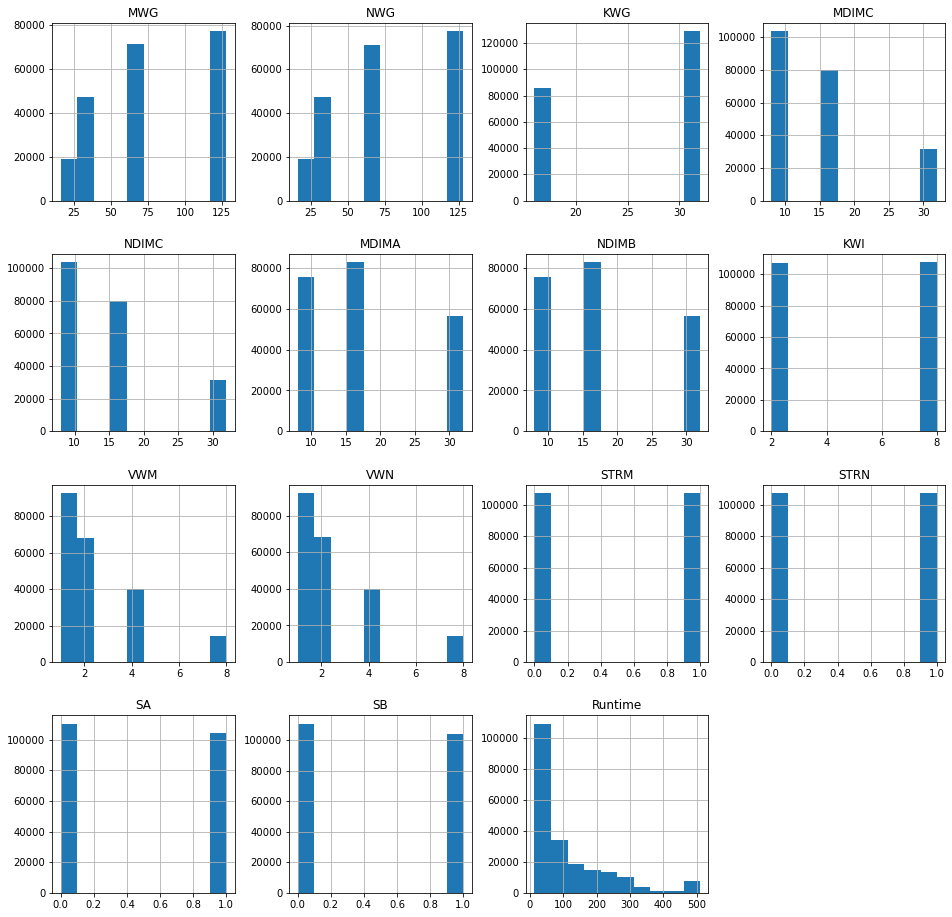

In [16]:
filtered_df.hist(figsize = (16,16));

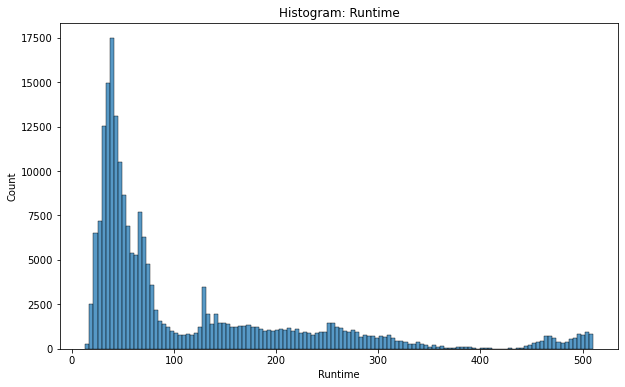

In [17]:
plt.figure(figsize = (10, 6))
sns.histplot(filtered_df["Runtime"]).set_title("Histogram: Runtime");

### As we can see from the histogram, the runtimes are a bit skewed towards the right.
### To correct this, we will transform the runtime with the natural logarithm of the values.

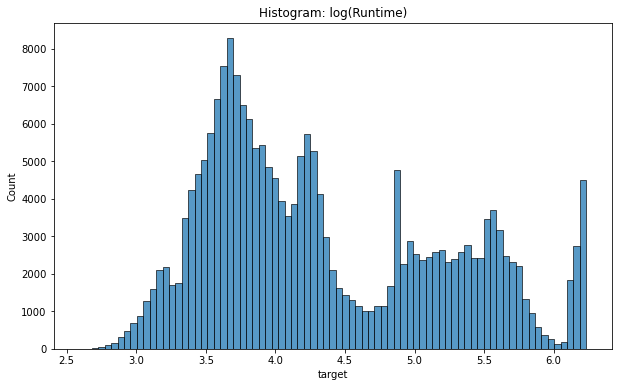

In [18]:
filtered_df["target"] = np.log(filtered_df["Runtime"])

plt.figure(figsize = (10, 6))
sns.histplot(filtered_df["target"]).set_title("Histogram: log(Runtime)");

### That looks better.

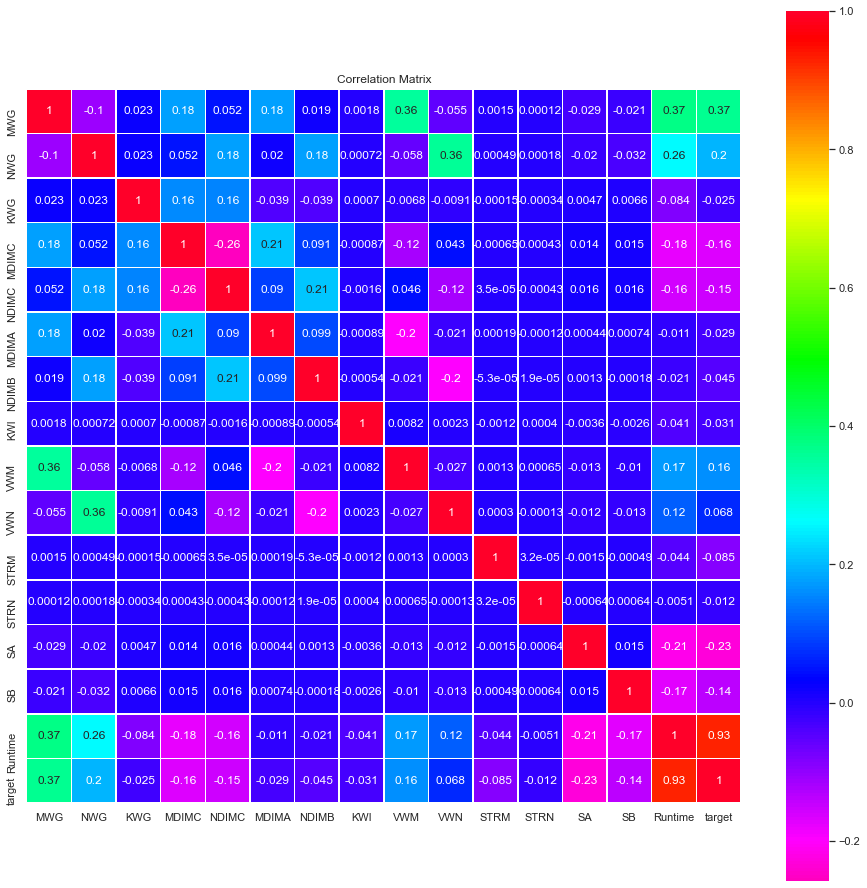

In [19]:
plt.figure(figsize = (16, 16))
sns.set(font_scale = 1)
sns.heatmap(filtered_df.corr(), cmap = "gist_rainbow_r", annot = True, square = True, linewidths = .5);
plt.title("Correlation Matrix");

### Creating binary classification target variable:

In [20]:
# Reducing data size to speed up computation
filtered_df = filtered_df.sample(frac = .2, random_state = 42)
filtered_df.shape

(42967, 16)

In [21]:
mean = filtered_df["target"].mean()
filtered_df.loc[filtered_df["target"] <= mean, "target"] = 0 # Fast runtime
filtered_df.loc[filtered_df["target"] > mean, "target"] = 1 # Slow runtime

target_arr = filtered_df["target"].values
target_arr = target_arr.astype(int)

features_arr = filtered_df.drop(columns = ["target", "Runtime"], axis = 1).values

In [22]:
target_arr

array([0, 0, 0, ..., 1, 0, 0])

In [23]:
features_arr

array([[ 64, 128,  16, ...,   0,   1,   0],
       [ 16, 128,  32, ...,   1,   1,   1],
       [128,  64,  16, ...,   0,   1,   0],
       ...,
       [128,  64,  16, ...,   1,   0,   1],
       [ 32, 128,  32, ...,   0,   1,   1],
       [ 64,  64,  32, ...,   1,   0,   1]])

### Splitting into training and testing data:

In [24]:
sc = StandardScaler()

train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# Training set is now 70% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(features_arr, target_arr, test_size = 1 - train_ratio, random_state = 42)

# Test set is now 15% of the initial data set
# Validation set is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = test_ratio/(test_ratio + validation_ratio), random_state = 42) 

X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

In [25]:
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)

X_train: (30076, 14)
X_val: (6445, 14)
X_test: (6446, 14)


In [26]:
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)
print("y_test:", y_test.shape)

y_train: (30076,)
y_val: (6445,)
y_test: (6446,)


## Linear Support Vector Machine
### Author: Kyle Calabro
---

In [27]:
lin_svc_clf = SVC(kernel = "linear")
lin_svc_clf.fit(X_train, y_train)

# Five fold cross validation
accuracies = cross_val_score(estimator = lin_svc_clf, X = X_train, y = y_train, cv = 5)

mean_lin_svc_clf = accuracies.mean()
std_lin_svc_clf = accuracies.std()

print("Five-Fold CV Scores:")
print("Mean of Accuracies:", mean_lin_svc_clf * 100)
print("Standard Deviation of Accuracies", std_lin_svc_clf * 100)

Five-Fold CV Scores:
Mean of Accuracies: 85.46016496878372
Standard Deviation of Accuracies 0.6490414666312858


In [ ]:
title = "Learning Curves (SVM, Linear Kernel)"
cv = ShuffleSplit(n_splits = 5, test_size = .3, random_state = 42)
plot_learning_curve(lin_svc_clf, title, features_arr, target_arr, (.8, 1.1), cv = cv)
plt.show()

In [28]:
y_pred_lin_svc_clf = lin_svc_clf.predict(X_val)

In [29]:
print("Evaluating on Validation Set Data (Linear SVM):\n")
print_performance_metrics(y_val, y_pred_lin_svc_clf)

Evaluating on Validation Set Data (Linear SVM):

Confusion Matrix:
[[3521  377]
 [ 596 1951]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      3898
           1       0.84      0.77      0.80      2547

    accuracy                           0.85      6445
   macro avg       0.85      0.83      0.84      6445
weighted avg       0.85      0.85      0.85      6445
 

Accuracy: 0.8490302560124128


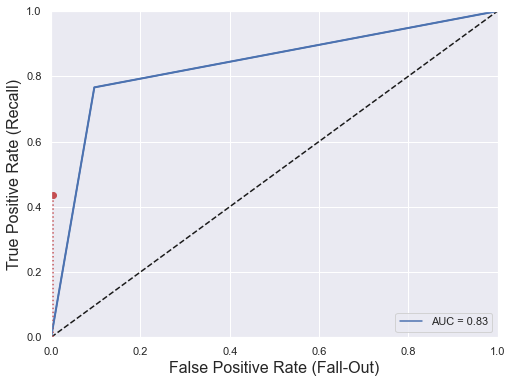

In [30]:
get_roc_plot(y_pred_lin_svc_clf, y_val)

## Polynomial Support Vector Machine
### Author: Kyle Calabro
---

In [31]:
poly_svc_clf = SVC(kernel = "poly")
poly_svc_clf.fit(X_train, y_train)

# Five fold cross validation
accuracies = cross_val_score(estimator = poly_svc_clf, X = X_train, y = y_train, cv = 5)

mean_poly_svc_clf = accuracies.mean()
std_poly_svc_clf = accuracies.std()

print("Five-Fold CV Scores:")
print("Mean of Accuracies:", mean_poly_svc_clf * 100)
print("Standard Deviation of Accuracies", std_poly_svc_clf * 100)

Five-Fold CV Scores:
Mean of Accuracies: 89.38024398224297
Standard Deviation of Accuracies 0.47268817651595896


In [ ]:
title = "Learning Curves (SVM, Polynomial Kernel)"
cv = ShuffleSplit(n_splits = 5, test_size = .3, random_state = 42)
plot_learning_curve(poly_svc_clf, title, features_arr, target_arr, (.8, 1.1), cv = cv)
plt.show()

In [32]:
y_pred_poly_svc_clf = poly_svc_clf.predict(X_val)

In [33]:
print("Evaluating on Validation Set Data (Polynomial SVM):\n")
print_performance_metrics(y_val, y_pred_poly_svc_clf)

Evaluating on Validation Set Data (Polynomial SVM):

Confusion Matrix:
[[3696  202]
 [ 475 2072]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      3898
           1       0.91      0.81      0.86      2547

    accuracy                           0.89      6445
   macro avg       0.90      0.88      0.89      6445
weighted avg       0.90      0.89      0.89      6445
 

Accuracy: 0.8949573312645461


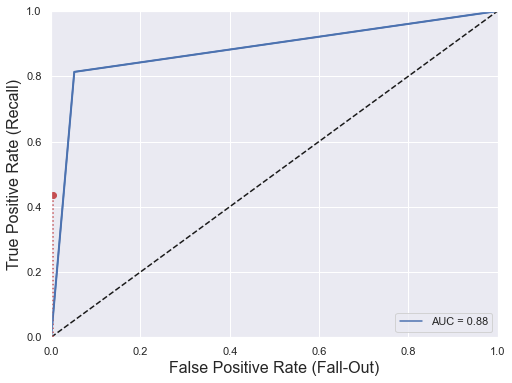

In [34]:
get_roc_plot(y_pred_poly_svc_clf, y_val)

## RBF Support Vector Machine
### Author: Kyle Calabro
---

In [35]:
rbf_svc_clf = SVC(kernel = "rbf")
rbf_svc_clf.fit(X_train, y_train)

# Five fold cross validation
accuracies = cross_val_score(estimator = rbf_svc_clf, X = X_train, y = y_train, cv = 5)

mean_rbf_svc_clf = accuracies.mean()
std_rbf_svc_clf = accuracies.std()

print("Five-Fold CV Scores:")
print("Mean of Accuracies:", mean_rbf_svc_clf * 100)
print("Standard Deviation of Accuracies", std_rbf_svc_clf * 100)

Five-Fold CV Scores:
Mean of Accuracies: 94.19138877098035
Standard Deviation of Accuracies 0.37689418858857054


In [ ]:
title = "Learning Curves (SVM, RBF Kernel)"
cv = ShuffleSplit(n_splits = 5, test_size = .3, random_state = 42)
plot_learning_curve(rbf_svc_clf, title, features_arr, target_arr, (.8, 1.1), cv = cv)
plt.show()

In [36]:
y_pred_rbf_svc_clf = rbf_svc_clf.predict(X_val)

In [37]:
print("Evaluating on Validation Set Data (RBF SVM):\n")
print_performance_metrics(y_val, y_pred_rbf_svc_clf)

Evaluating on Validation Set Data (RBF SVM):

Confusion Matrix:
[[3813   85]
 [ 292 2255]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      3898
           1       0.96      0.89      0.92      2547

    accuracy                           0.94      6445
   macro avg       0.95      0.93      0.94      6445
weighted avg       0.94      0.94      0.94      6445
 

Accuracy: 0.9415050426687355


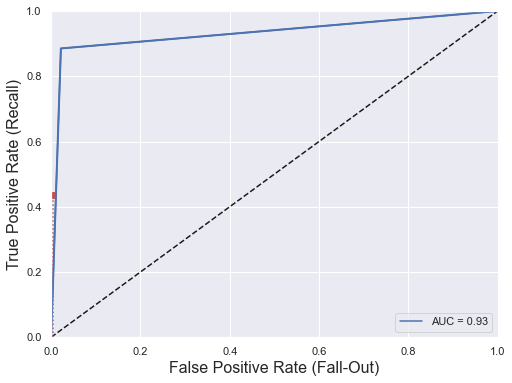

In [38]:
get_roc_plot(y_pred_rbf_svc_clf, y_val)

## Decision Tree with Entropy as Impurity Measure
### Author: Kyle Calabro
---

In [39]:
entropy_dt_clf = DecisionTreeClassifier(criterion = "entropy", random_state = 42)
entropy_dt_clf.fit(X_train, y_train)

# Five fold cross validation
accuracies = cross_val_score(estimator = entropy_dt_clf, X = X_train, y = y_train, cv = 5)

mean_edt_clf = accuracies.mean()
std_edt_clf = accuracies.std()

print("Five-Fold CV Scores:")
print("Mean of Accuracies:", mean_edt_clf * 100)
print("Standard Deviation of Accuracies", std_edt_clf * 100)

Five-Fold CV Scores:
Mean of Accuracies: 97.44314634513009
Standard Deviation of Accuracies 0.10941792656949001


In [40]:
y_pred_edt = entropy_dt_clf.predict(X_val)

In [41]:
print("Evaluating on Validation Set Data (Decision Tree with Entropy):\n")
print_performance_metrics(y_val, y_pred_edt)

Evaluating on Validation Set Data (Decision Tree with Entropy):

Confusion Matrix:
[[3821   77]
 [  81 2466]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3898
           1       0.97      0.97      0.97      2547

    accuracy                           0.98      6445
   macro avg       0.97      0.97      0.97      6445
weighted avg       0.98      0.98      0.98      6445
 

Accuracy: 0.9754848719937936


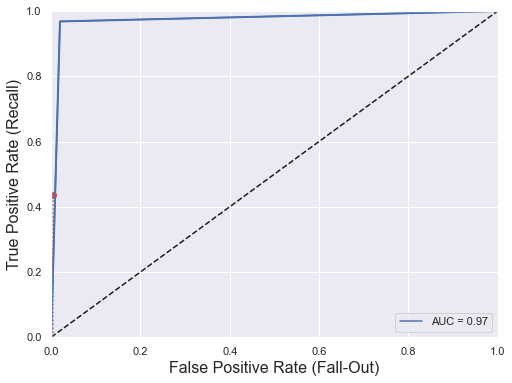

In [42]:
get_roc_plot(y_pred_edt, y_val)

## Decision Tree with Gini as Impurity Measure
### Author: Kyle Calabro
---

In [43]:
gini_dt_clf = DecisionTreeClassifier(criterion = "gini", random_state = 42)
gini_dt_clf.fit(X_train, y_train)

# Five fold cross validation
accuracies = cross_val_score(estimator = gini_dt_clf, X = X_train, y = y_train, cv = 5)

mean_gdt_clf = accuracies.mean()
std_gdt_clf = accuracies.std()

print("Five-Fold CV Scores:")
print("Mean of Accuracies:", mean_gdt_clf * 100)
print("Standard Deviation of Accuracies", std_gdt_clf * 100)

Five-Fold CV Scores:
Mean of Accuracies: 97.37332975186149
Standard Deviation of Accuracies 0.14589892958848957


In [44]:
y_pred_gdt = gini_dt_clf.predict(X_val)

In [45]:
print("Evaluating on Validation Set Data (Decision Tree with Gini):\n")
print_performance_metrics(y_val, y_pred_gdt)

Evaluating on Validation Set Data (Decision Tree with Gini):

Confusion Matrix:
[[3835   63]
 [  76 2471]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3898
           1       0.98      0.97      0.97      2547

    accuracy                           0.98      6445
   macro avg       0.98      0.98      0.98      6445
weighted avg       0.98      0.98      0.98      6445
 

Accuracy: 0.978432893716059


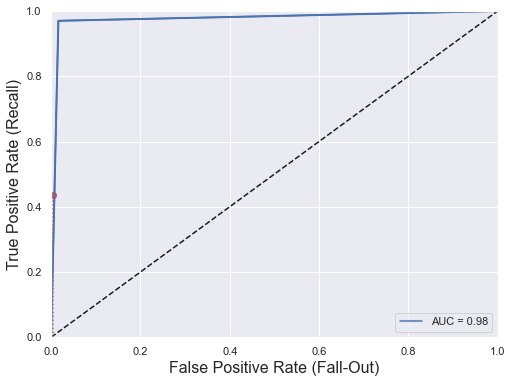

In [46]:
get_roc_plot(y_pred_gdt, y_val)

### The Decision Tree utilizing Gini as the impurity measure offers a slightly higher accuracy, so we will move forward with that model.

### Pruning the Gini-based Decision Tree:

In [47]:
params = [{"criterion" : ["gini"], "min_samples_leaf" : [5, 10, 20, 30, 50, 100], "max_depth" : [1, 5, 10, 20, 50, 100, 200]}]

grid_search = GridSearchCV(estimator = gini_dt_clf, param_grid = params, scoring = "accuracy", cv = 10, n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)

best_acc = grid_search.best_score_
best_params = grid_search.best_params_

print("Accuracy:", best_acc)
print("Best Parameters:", best_params)

Accuracy: 0.9700424740322227
Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5}


In [48]:
pr_gini_dt_clf = DecisionTreeClassifier(criterion = "gini", max_depth = 20, min_samples_leaf = 5, random_state = 42)
pr_gini_dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20, min_samples_leaf=5, random_state=42)

In [49]:
y_pred_pr_gdt = pr_gini_dt_clf.predict(X_val)

In [50]:
print("Evaluating on Validation Set Data (Pruned Decision Tree with Gini):\n")
print_performance_metrics(y_val, y_pred_pr_gdt)

Evaluating on Validation Set Data (Pruned Decision Tree with Gini):

Confusion Matrix:
[[3847   51]
 [ 103 2444]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3898
           1       0.98      0.96      0.97      2547

    accuracy                           0.98      6445
   macro avg       0.98      0.97      0.97      6445
weighted avg       0.98      0.98      0.98      6445
 

Accuracy: 0.9761055081458495


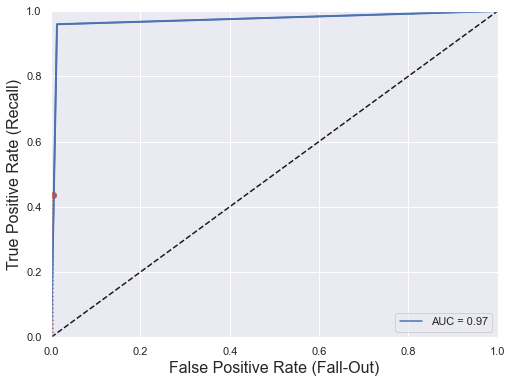

In [51]:
get_roc_plot(y_pred_pr_gdt, y_val)

## Boosting
### Author: Kyle Calabro
---

### Gradient Boosting

In [52]:
grad_boost_clf = GradientBoostingClassifier(learning_rate = .01, random_state = 42)
grad_boost_clf.fit(X_train, y_train)

# Five fold cross validation
accuracies = cross_val_score(estimator = grad_boost_clf, X = X_train, y = y_train, cv = 5)

mean_grad_boost_clf = accuracies.mean()
std_grad_boost_clf = accuracies.std()

print("Five-Fold CV Scores:")
print("Mean of Accuracies:", mean_grad_boost_clf * 100)
print("Standard Deviation of Accuracies", std_grad_boost_clf * 100)

Five-Fold CV Scores:
Mean of Accuracies: 76.01408049026371
Standard Deviation of Accuracies 1.547962381105057


In [53]:
y_pred_grad_boost_clf = grad_boost_clf.predict(X_val)

In [54]:
print("Evaluating on Validation Set Data (Gradient Boosting):\n")
print_performance_metrics(y_val, y_pred_grad_boost_clf)

Evaluating on Validation Set Data (Gradient Boosting):

Confusion Matrix:
[[3607  291]
 [1347 1200]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.93      0.81      3898
           1       0.80      0.47      0.59      2547

    accuracy                           0.75      6445
   macro avg       0.77      0.70      0.70      6445
weighted avg       0.76      0.75      0.73      6445
 

Accuracy: 0.7458494957331264


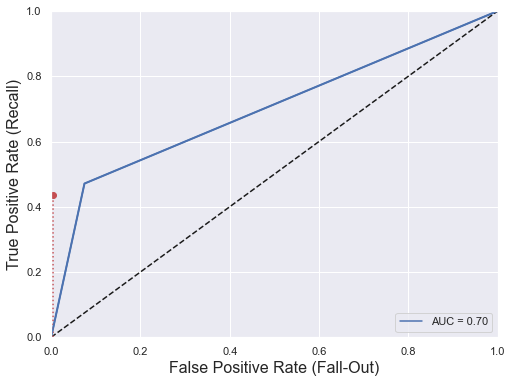

In [55]:
get_roc_plot(y_pred_grad_boost_clf, y_val)

### ADA Boosting

In [56]:
ADA_boost_clf = AdaBoostClassifier(random_state = 42)
ADA_boost_clf.fit(X_train, y_train)

# Five fold cross validation
accuracies = cross_val_score(estimator = ADA_boost_clf, X = X_train, y = y_train, cv = 5)

mean_ada_boost_clf = accuracies.mean()
std_ada_boost_clf = accuracies.std()

print("Five-Fold CV Scores:")
print("Mean of Accuracies:", mean_ada_boost_clf * 100)
print("Standard Deviation of Accuracies", std_ada_boost_clf * 100)

Five-Fold CV Scores:
Mean of Accuracies: 80.48943521073204
Standard Deviation of Accuracies 0.6359898221327199


In [57]:
y_pred_ada_boost_clf = ADA_boost_clf.predict(X_val)

In [58]:
print("Evaluating on Validation Set Data (AdaBoost):\n")
print_performance_metrics(y_val, y_pred_ada_boost_clf)

Evaluating on Validation Set Data (AdaBoost):

Confusion Matrix:
[[3334  564]
 [ 754 1793]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.83      3898
           1       0.76      0.70      0.73      2547

    accuracy                           0.80      6445
   macro avg       0.79      0.78      0.78      6445
weighted avg       0.79      0.80      0.79      6445
 

Accuracy: 0.795500387897595


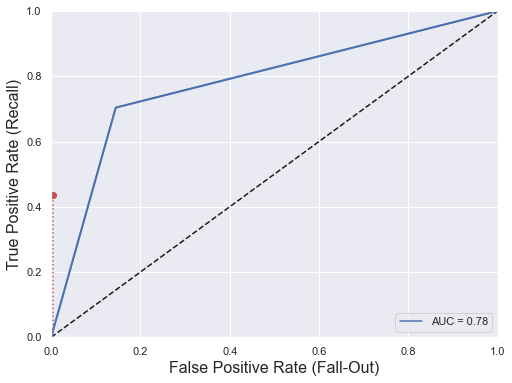

In [59]:
get_roc_plot(y_pred_ada_boost_clf, y_val)

In [60]:
params = [{"n_estimators" : [50, 100, 200, 300, 500, 1000, 1500]}]

grid_search = GridSearchCV(estimator = ADA_boost_clf, param_grid = params, scoring = "accuracy", cv = 10, n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)

best_acc = grid_search.best_score_
best_params = grid_search.best_params_

print("Accuracy:", best_acc)
print("Best Parameters:", best_params)

Accuracy: 0.8053934878899588
Best Parameters: {'n_estimators': 50}


In [61]:
ADA_boost_clf2 = AdaBoostClassifier(n_estimators = 50, random_state = 42)
ADA_boost_clf2.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

In [62]:
y_pred_ada_boost_clf2 = ADA_boost_clf2.predict(X_val)

In [63]:
print("Evaluating on Validation Set Data (AdaBoost via GridSearchCV):\n")
print_performance_metrics(y_val, y_pred_ada_boost_clf2)

Evaluating on Validation Set Data (AdaBoost via GridSearchCV):

Confusion Matrix:
[[3334  564]
 [ 754 1793]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.83      3898
           1       0.76      0.70      0.73      2547

    accuracy                           0.80      6445
   macro avg       0.79      0.78      0.78      6445
weighted avg       0.79      0.80      0.79      6445
 

Accuracy: 0.795500387897595


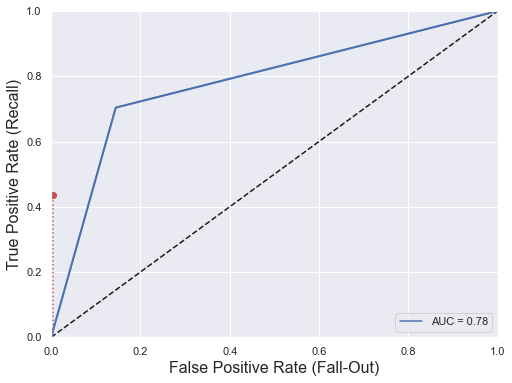

In [64]:
get_roc_plot(y_pred_ada_boost_clf2, y_val)